# Follow-the-Leader (FTL) strategy

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from functools import partial

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
key = jax.random.PRNGKey(3141)
key_oracle, key_agent = jax.random.split(key, 2)

T = 2000 # 500
y = jax.random.uniform(key_oracle, (T,), minval=0, maxval=1)
y = jax.random.bernoulli(key_oracle, p=0.4, shape=(T,))
y = jax.random.beta(key_oracle, a=0.5, b=0.5, shape=(T,))

In [4]:
y = jnp.arange(T) % 2

y

Array([0, 1, 0, ..., 1, 0, 1], dtype=int32)

In [5]:
trange = jnp.arange(T)
@partial(jax.vmap, in_axes=(0, None, None, None))
def regret_step(t, yseq, xseq, trange):    
    yseq = yseq + (trange > t) * jnp.nan
    x_agent = xseq + (trange > t) * jnp.nan
    x_oracle = jnp.nanmean(yseq)
    
    regret = jnp.nansum((x_agent - yseq) ** 2)
    regret = regret - jnp.nansum((x_oracle - yseq) ** 2)
    
    return regret

In [6]:
x_ftl = y.cumsum() / (1 + trange)
x_ftl = jnp.roll(x_ftl, 1)
x_ftl = x_ftl.at[0].set(0)

regret = regret_step(trange[1:], y[1:], x_ftl[1:], trange[1:])

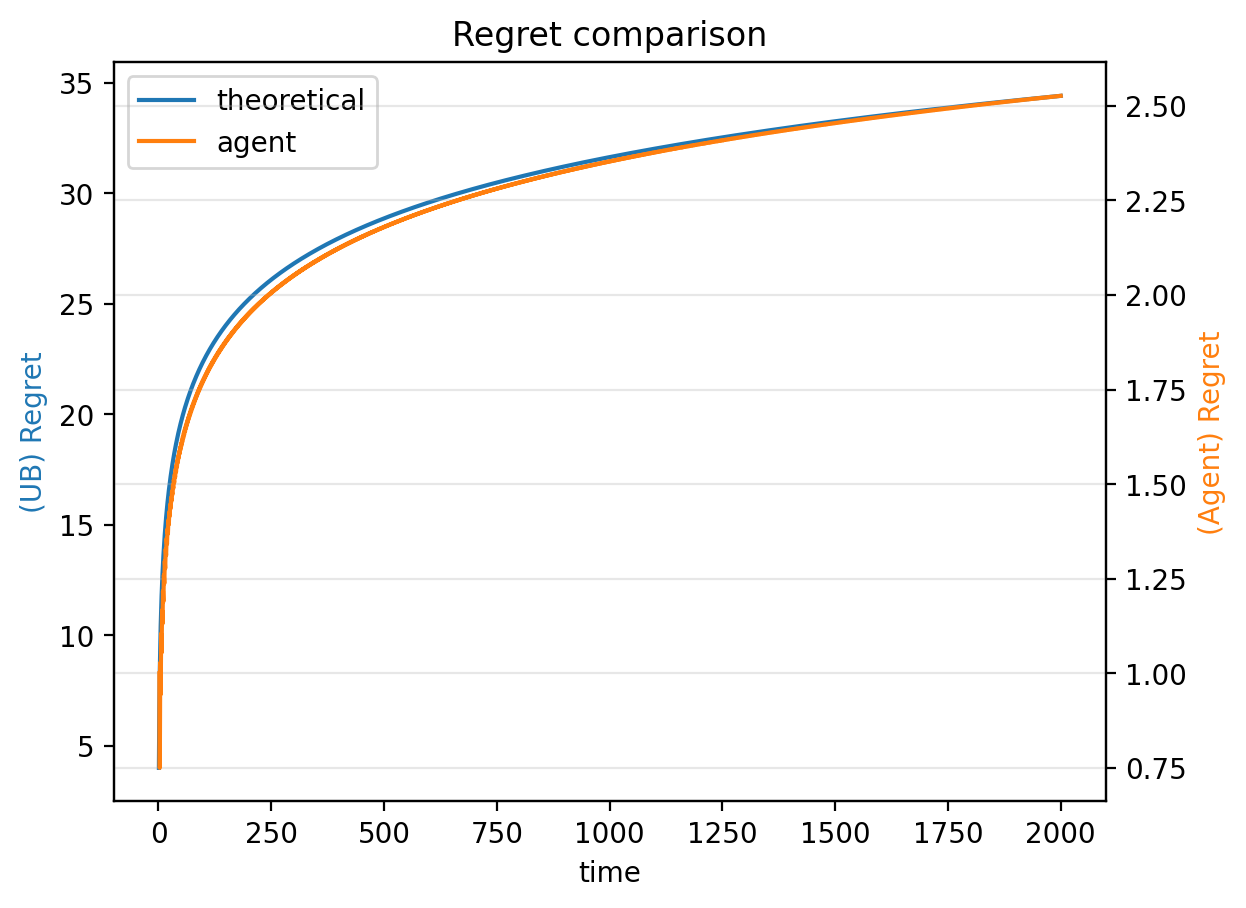

In [15]:
trange = jnp.arange(1, T+1)
ubound = 4 + 4 * jnp.log(trange)

fig, ax = plt.subplots()
ax2 = ax.twinx()

l1 = ax.plot(trange, ubound, label="theoretical")
l2 = ax2.plot(trange[1:], regret, label="agent", c="tab:orange")

ax.yaxis.label.set_color("tab:blue")
ax2.yaxis.label.set_color("tab:orange")

lines = l1 + l2
labels = [l.get_label() for l in lines]

ax.set_ylabel("(UB) Regret")
ax2.set_ylabel("(Agent) Regret")
ax.set_xlabel("time")
ax.legend(lines, labels)
plt.title("Regret comparison")
plt.grid(alpha=0.3)

## Failure of FTL

In [60]:
@jax.jit
def z(t):
    cond1 = t % 2 == 0
    cond2 = (t % 2 == 1) * (t > 1)
    cond3 = t == 1
    
    res = (
        cond1 *  1 +
        cond2 * -1 +
        cond3 * -0.5
    )
    
    return res

@jax.jit
def x(t, x1=1.0):
    """
    Agent strategy
    """
    cond1 = t % 2 == 0
    cond2 = (t % 2 == 1) * (t > 1)
    cond3 = t == 1
    
    res = (
        cond1 * 1 +
        cond2 * -1 + 
        cond3 * x1
    )
    
    return res

def loss_fn(t, agent_fn):
    xt = agent_fn(t)
    
    return z(t) * xt

In [61]:
def step_learn(cum_loss, t, agent_fn):
    loss = loss_fn(t, agent_fn=agent_fn)
    
    cum_loss = cum_loss + loss
    
    return cum_loss, cum_loss

In [62]:
# Regret v.s. adversary u=0 is T - 1 - x1 / 2
T = 100

timesteps = jnp.arange(1, T + 1)

_, hist_loss = jax.lax.scan(partial(step_learn, agent_fn=x), 0.0, timesteps)
hist_loss

Array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5,
       21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5,
       32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5,
       43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5,
       54.5, 55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5,
       65.5, 66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5, 73.5, 74.5, 75.5,
       76.5, 77.5, 78.5, 79.5, 80.5, 81.5, 82.5, 83.5, 84.5, 85.5, 86.5,
       87.5, 88.5, 89.5, 90.5, 91.5, 92.5, 93.5, 94.5, 95.5, 96.5, 97.5,
       98.5], dtype=float32, weak_type=True)